In [48]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [50]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose

class ImageDataset(Dataset):
    def __init__(self, image_dir, image_dir_2, transform=None):
        self.image_dir = image_dir
        self.image_dir_2 = image_dir_2
        self.image_files = [i for i in os.listdir(image_dir) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.images_files_2 = [i for i in os.listdir(image_dir_2) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform
 
    def len(self):
        return len(self.image_files)

    def getItem(self, dirc, files, idx):
        img_path = os.path.join(dirc, files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image  
    
    def getDataset(self, limit):
        total_dataset = []
        for i in range(1, limit):
            if i % 1000 == 0:
                print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append([self.getItem(dirc =self.image_dir, files=self.image_files, idx=i), self.getItem(dirc =self.image_dir_2, files=self.images_files_2, idx=i)])
        return total_dataset

In [51]:
from dotenv import load_dotenv
import os

load_dotenv()
clean_dir = os.environ["DATA_DIR"]
noise_dir = os.environ['DATA_DIR_2']

In [52]:
transformations = Compose([
    ToTensor(), 
])

train_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(3001)
test_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(2001)

Have reached 1000/31500
Have reached 2000/31500
Have reached 3000/31500
Have reached 1000/31500
Have reached 2000/31500


In [53]:
len(train_dataset)

3000

In [54]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
train_image_batches, train_target_batches = next(iter(train_dataloader))

In [56]:
train_image_batches.shape, train_target_batches.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 1, 256, 256]))

In [66]:
import matplotlib.pyplot as plt

rand = torch.randint(low=1, high=32, size=(1,)).item()
test_image = train_image_batches[rand]
test_target = train_target_batches[rand]

def compare_plots(test_image, test_target):
    plt.figure(figsize=(9,9))
    plt.subplot(3,3, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title('clean')
    plt.axis(False)
    plt.subplot(3,3,2)
    plt.imshow(test_target.squeeze(), cmap='gray')
    plt.title('noisy')
    plt.axis(False)
    plt.show()


In [58]:
class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(6)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
    
        self.tanh_layer = nn.Tanh()

    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        res = self.final_stack(x)
        despeckle = initial/(res)
        img = self.tanh_layer(despeckle)
        return img

In [59]:
model0 = SARDespeckleModel(
    input_shape=1,
    hidden_units=64,
    output_shape=1,
)
model0.to(device)

SARDespeckleModel(
  (initial_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (middle_stack): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [60]:
# import torchmetrics
# from torchmetrics.image import TotalVariation

# def loss_fn(img, ):
#     euc = torch.sqrt((x - y)**2).sum()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.01)

In [61]:
model0.state_dict()

OrderedDict([('initial_stack.0.weight',
              tensor([[[[-2.2745e-01, -1.0303e-01,  2.8950e-01],
                        [ 1.5707e-01, -1.6951e-01, -5.0524e-02],
                        [ 3.1629e-01, -2.5260e-01, -1.5196e-01]]],
              
              
                      [[[ 4.5992e-02, -2.8307e-01,  7.6690e-02],
                        [ 1.6248e-01, -2.2273e-02,  1.3873e-01],
                        [-2.7760e-01,  1.1094e-01,  9.0449e-02]]],
              
              
                      [[[ 1.5577e-01,  1.5698e-01,  3.1659e-01],
                        [-2.7737e-01, -6.2503e-02, -1.6556e-01],
                        [ 2.8163e-01,  2.9649e-01,  3.1347e-01]]],
              
              
                      [[[ 2.9333e-01,  2.5926e-02,  2.2903e-01],
                        [-8.6131e-02,  1.5181e-01, -2.9490e-01],
                        [-3.8679e-02, -2.0964e-01, -3.2328e-01]]],
              
              
                      [[[-5.1383e-02, -2.3473e-01,  

In [62]:
from tqdm.auto import tqdm

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    total_loss =0
    model0.to(device)
    for batch, (clean_img, noise_img) in enumerate(train_dataloader):
        model0.train()
        clean_img, noise_img = clean_img.to(device), noise_img.to(device)
        img_pred = model0(noise_img)
        loss = mse_loss(img_pred, clean_img)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 ==0:
            print(f"We have passed {batch * len(clean_img)}/{len(train_dataloader.dataset)} samples")
            print(f'Current Accumalting Loss: {loss:.2f}\n---------')
        
    total_loss /= len(train_dataloader)
    print(f"So far our train loss has been: {total_loss:.3f}%")



  0%|          | 0/3 [00:00<?, ?it/s]

We have passed 0/3000 samples
Current Accumalting Loss: nan
---------
We have passed 320/3000 samples
Current Accumalting Loss: 0.05
---------
We have passed 640/3000 samples
Current Accumalting Loss: 0.05
---------
We have passed 960/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 1280/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 1600/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 1920/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 2240/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 2560/3000 samples
Current Accumalting Loss: 0.04
---------
We have passed 2880/3000 samples
Current Accumalting Loss: 0.04
---------
So far our train loss has been: nan%
We have passed 0/3000 samples
Current Accumalting Loss: 0.05
---------
We have passed 320/3000 samples
Current Accumalting Loss: 0.03
---------
We have passed 640/3000 samples
Current Accumalting Loss: 0.04
---------
We have passe

In [64]:
model0.eval()
test_loss = 0
test_img_pred = 0
test_img_label = 0
with torch.inference_mode():
    for (y, X) in test_dataloader:
        y, X = y.to(device), X.to(device)
        img_pred = model0(X)
        test_loss += mse_loss(img_pred, y)
        test_img_pred = img_pred
        test_img_label = y

    test_loss /= len(test_dataloader)

print(f'Test loss: {test_loss}')

Test loss: 0.04331041872501373


In [68]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'sar_model'
MODEL_SAVE_PATH = MODEL_PATH/ MODEL_NAME

print(f'saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

saving model to models\sar_model


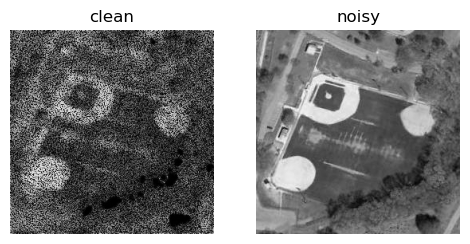

In [78]:
test_img_pred, test_img_label = test_img_pred[0].to('cpu'), test_img_label[0].to('cpu')

compare_plots(test_img_pred, test_img_label)